In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle

from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from keras import backend as K
# from vis.utils import utils
from keras import activations
# from vis.visualization import visualize_activation, get_num_filters
# from vis.input_modifiers import Jitter

# **Funciones útiles**


In [ ]:
# proporcionamos herramientas útiles para el análisis y visualización
# del rendimiento de modelos de aprendizaje automático.
# Incluye funciones para suavizar métricas, graficar resultados, manipular imágenes y manejar la persistencia de datos.
# Estas funciones son esenciales para evaluar y mejorar nuestro modelo modelo.

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    epochs = range(1, steps + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
    plt.plot(epochs, val_acc, 'b', label='Validación acc')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
    plt.title('Pérdida de entrenamiento y validación.')
    plt.legend()

    plt.grid(True, linestyle='--')
    plt.show()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# **Obtención de imágenes**

Para la obtención de imágenes de cebras y zorros, utilizamos una base de datos disponible en Kaggle. Hemos seleccionado un total de 240 imágenes para cada uno de los dos animales, almacenándolas en una carpeta denominada DataSet_images. Todas las imágenes han sido normalizadas a una dimensión uniforme de 256 x 256 píxeles para asegurar consistencia en el procesamiento posterior.

Las imágenes se han dividido en tres conjuntos para diferentes etapas del aprendizaje automático:

- Entrenamiento: 70% de las imágenes, lo que corresponde a 168 imágenes de cebras y 168 imágenes de zorros.

- Validación: 15% de las imágenes, lo que corresponde a 36 imágenes de cebras y 36 imágenes de zorros.

- Prueba: 15% de las imágenes restantes, lo que corresponde a 36 imágenes de cebras y 36 imágenes de zorros.

Esta división garantiza que los conjuntos de datos de entrenamiento, validación y prueba estén equilibrados y listos para su uso. Asimismo, [1] según  Santos, P.R en enero del 202 señala que normalmente al tener un conjunto de datos estos se repartan en un 70% de datos de entrenamiento y un 30% de datos de test, pero esto puede variar en proporción y va ha depender del caso del que se esta tratando, pero lo importante es que se trate de que no exista algún sobreajuste u 'overfitting'.



In [ ]:
%%capture
!pip install kaggle

In [ ]:
# Usaremos el token de la API de kaggle
kaggle_username = 'persona'
kaggle_key = 'cd68a18390f808dac268'

# Configuramos las variables de entorno para Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [ ]:
%%capture
!kaggle datasets list

In [ ]:
import kaggle

# Definimos el nombre del dataset desde kaggle
dataset_cebras = 'arnaud58/horse2zebra'
dataset_zorros = 'peacehegemony/494-fox-labeled-image-dataset'

# Definimos el directorio de destino
destination_dir = '/content/dataset'

# Creamos el directorio si no existe
os.makedirs(destination_dir)

# Descargamos el dataset completo delas imágenes
kaggle.api.dataset_download_files(dataset_cebras, path=destination_dir, unzip=True)
kaggle.api.dataset_download_files(dataset_zorros, path=destination_dir, unzip=True)

print(f'Dataset descargado y descomprimido en {destination_dir}')


Dataset URL: https://www.kaggle.com/datasets/arnaud58/horse2zebra
Dataset URL: https://www.kaggle.com/datasets/peacehegemony/494-fox-labeled-image-dataset
Dataset descargado y descomprimido en /content/dataset


In [ ]:
# preparamos un conjunto de datos al seleccionar y organizar imágenes
# de diferentes categorías en nuevas carpetas. Puesto que,
# La selección aleatoria y el movimiento de archivos son tareas comunes en la preparación de datos para
# proyectos de aprendizaje automático o procesamiento de imágenes.

In [ ]:
import shutil
import random

ruta_zorros = '/content/dataset/images.cv_8rk8h3aklzqjr2tcx76b7/data/train/animal fox'
ruta_cebras = '/content/dataset/horse2zebra/trainB'

num_imagenes_deseadas = 240

# Obtenemos la lista de todas las imágenes en la carpeta
imagenes_zorros = os.listdir(ruta_zorros)
imagenes_cebras = os.listdir(ruta_cebras)

# Seleccionar aleatoriamente 240 imágenes de cada carpeta
imagenes_seleccionadas_zorros = random.sample(imagenes_zorros, num_imagenes_deseadas)
imagenes_seleccionadas_cebras = random.sample(imagenes_cebras, num_imagenes_deseadas)

# Crear una carpeta para almacenar las 240 imágenes seleccionadas
carpeta_dataset_zorros = '/content/DataSet_images/imagenes_zorros'
carpeta_dataset_cebras = '/content/DataSet_images/imagenes_cebras'

os.makedirs(carpeta_dataset_zorros, exist_ok=True)
os.makedirs(carpeta_dataset_cebras, exist_ok=True)

# Mover las imágenes seleccionadas a la carpeta DataSet_images
for imagen_zorro, imagen_cebra in zip(imagenes_seleccionadas_zorros, imagenes_seleccionadas_cebras):
    ruta_origen_zorros = os.path.join(ruta_zorros, imagen_zorro)
    ruta_origen_cebras = os.path.join(ruta_cebras, imagen_cebra)

    ruta_destino_zorros = os.path.join(carpeta_dataset_zorros, imagen_zorro)
    ruta_destino_cebras = os.path.join(carpeta_dataset_cebras, imagen_cebra)

    shutil.move(ruta_origen_zorros, ruta_destino_zorros)
    shutil.move(ruta_origen_cebras, ruta_destino_cebras)


print(f"Imágenes movidas exitosamente a la carpeta 'DataSet_images'.")

Imágenes movidas exitosamente a la carpeta 'DataSet_images'.


In [ ]:
nombres_imagenes_zorros = os.listdir(carpeta_dataset_zorros)
nombres_imagenes_cebras = os.listdir(carpeta_dataset_cebras)

In [ ]:
num_zorros = len(nombres_imagenes_zorros)
num_cebras = len(nombres_imagenes_cebras)

print(f"El número de imágenes en la carpeta de zorros es de {num_zorros}")
print(f"El número de imágenes en la carpeta de cebras es de {num_cebras}")

El número de imágenes en la carpeta de zorros es de 240
El número de imágenes en la carpeta de cebras es de 240


In [ ]:
nombres_imagenes_zorros[:10]

['XS46GTRTB46D_aug.jpg',
 '98SHFPFNVBW7.jpg',
 'DL18BBYMPUBV.jpg',
 'FY08PRVLLYQT.jpg',
 'JBZ6T4N1SJ96.jpg',
 'Z6AZ8T7C2J6O.jpg',
 'VXBAXNX1INTM_aug.jpg',
 'MR48K6KK9FEZ.jpg',
 'RMOJ21NERMTE.jpg',
 'UOBST7T8HINL.jpg']

In [ ]:
nombres_imagenes_cebras[:10]

['n02391049_3137.jpg',
 'n02391049_1211.jpg',
 'n02391049_8178.jpg',
 'n02391049_9762.jpg',
 'n02391049_8214.jpg',
 'n02391049_635.jpg',
 'n02391049_2481.jpg',
 'n02391049_5371.jpg',
 'n02391049_6465.jpg',
 'n02391049_10336.jpg']

In [ ]:
# A continuación visualizamos las  imágenes de diferentes categorías en un formato organizado.
# donde nos permita ver varias imágenes al mismo tiempo, junto con sus nombres y dimensiones,
# lo que es especialmente útil para la inspección de conjuntos de datos.

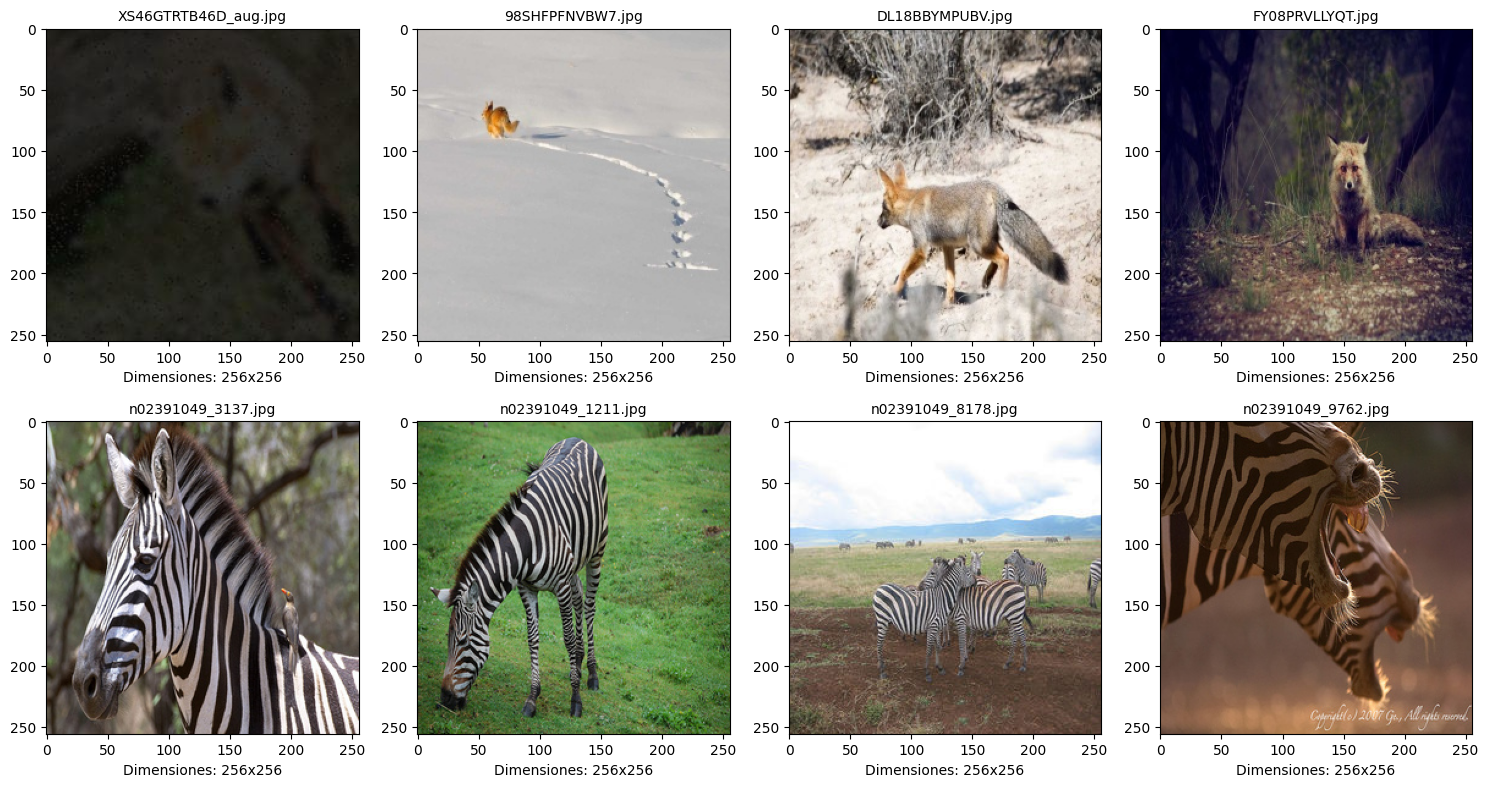

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Número de imágenes que quieres mostrar por fila y columna
num_columnas = 4
num_filas = 2
num_imagenes = num_columnas * num_filas

# Crear la figura y los subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 8))

# Concatenar las listas de imágenes para mostrarlas todas
imagenes = [(carpeta_dataset_zorros, img) for img in nombres_imagenes_zorros[:num_imagenes//2]] + \
           [(carpeta_dataset_cebras, img) for img in nombres_imagenes_cebras[:num_imagenes//2]]

# Recorrer los subplots y cargar las imágenes correspondientes
for ax, (carpeta, nombre_imagen) in zip(axes.flatten(), imagenes):
    ruta_imagen = os.path.join(carpeta, nombre_imagen)
    imagen = mpimg.imread(ruta_imagen)

    # Obtener las dimensiones de la imagen
    altura, ancho = imagen.shape[:2]

    # Mostrar la imagen
    ax.imshow(imagen)

    # Agregar el nombre de la imagen como título
    ax.set_title(nombre_imagen, fontsize=10)

    # Mostrar las dimensiones en el eje x
    ax.set_xlabel(f'Dimensiones: {ancho}x{altura}', fontsize=10)


# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()


In [ ]:
# Como se podrá observar, las dimensiones de cada imagen son las mismas.

In [ ]:
def dividir_imagenes(carpeta_original, nombres_imagenes, carpeta_entrenamiento, carpeta_validacion, carpeta_prueba):
    # Creamos las carpetas si no existen
    os.makedirs(carpeta_entrenamiento, exist_ok=True)
    os.makedirs(carpeta_validacion, exist_ok=True)
    os.makedirs(carpeta_prueba, exist_ok=True)

    # Mezclamos las imágenes de manera aleatoria
    random.shuffle(nombres_imagenes)

    # Calculamos la cantidad de imágenes para cada conjunto
    total_imagenes = len(nombres_imagenes)
    num_entrenamiento = int(0.70 * total_imagenes)
    num_validacion = int(0.15 * total_imagenes)
    num_prueba = total_imagenes - num_entrenamiento - num_validacion

    # Dividimos las imágenes en tres conjuntos
    imagenes_entrenamiento = nombres_imagenes[:num_entrenamiento]
    imagenes_validacion = nombres_imagenes[num_entrenamiento:num_entrenamiento + num_validacion]
    imagenes_prueba = nombres_imagenes[num_entrenamiento + num_validacion:]

    # Mueve las imágenes a las carpetas correspondientes
    for img in imagenes_entrenamiento:
        shutil.move(os.path.join(carpeta_original, img), os.path.join(carpeta_entrenamiento, img))

    for img in imagenes_validacion:
        shutil.move(os.path.join(carpeta_original, img), os.path.join(carpeta_validacion, img))

    for img in imagenes_prueba:
        shutil.move(os.path.join(carpeta_original, img), os.path.join(carpeta_prueba, img))

    print("División completada!")

In [ ]:
# Dividiremos las imágenes de los zorros

carpeta_original_zorros = "/content/DataSet_images/imagenes_zorros"
carpeta_entrenamiento_zorros = "/content/entrenamiento/zorros"
carpeta_validacion_zorros = "/content/validacion/zorros"
carpeta_prueba_zorros = "/content/prueba/zorros"

dividir_imagenes(carpeta_original_zorros, nombres_imagenes_zorros, carpeta_entrenamiento_zorros, carpeta_validacion_zorros, carpeta_prueba_zorros)

División completada!


In [ ]:
# Dividiremos las imágenes de los zorros

carpeta_original_cebras = "/content/DataSet_images/imagenes_cebras"
carpeta_entrenamiento_cebras = "/content/entrenamiento/cebras"
carpeta_validacion_cebras = "/content/validacion/cebras"
carpeta_prueba_cebras = "/content/prueba/cebras"

dividir_imagenes(carpeta_original_cebras, nombres_imagenes_cebras, carpeta_entrenamiento_cebras, carpeta_validacion_cebras, carpeta_prueba_cebras)

División completada!


# **Definición de modelo**

En este proyecto, estamos utilizando capas convolucionales y de pooling para permitir que nuestro modelo aprenda representaciones espaciales jerárquicas de las imágenes, lo cual es fundamental para mejorar la precisión en la clasificación de imágenes. [2] Las capas convolucionales son especialmente efectivas para detectar características locales como bordes y texturas, mientras que las capas de pooling ayudan a reducir la dimensionalidad, preservando la información relevante.

Además, el modelo sigue una arquitectura secuencial, lo que significa que las capas se apilan de manera lineal. Esta estructura facilita la construcción y comprensión del modelo, ya que cada capa se añade directamente después de la anterior sin conexiones complejas.Para evitar el sobreajuste del modelo a los datos de entrenamiento, se está utilizando la regularización mediante dropout. [3] Srivastava et al en el año 2024 afirman que dropout promueve la robustez del modelo y mejora su capacidad para generalizar a datos no vistos, al desactivar aleatoriamente ciertas neuronas durante el entrenamiento.

Asimismo, se ha implementado una estrategia de optimización y una función de pérdida adecuadas para ajustar automáticamente las tasas de aprendizaje para cada parámetro del modelo. Esto facilita una convergencia rápida y estable, mejorando el rendimiento del modelo.

Finalmente, se ha incorporado un generador de datos que permite cargar y procesar imágenes en tiempo real durante el entrenamiento. Esta técnica es esencial para manejar grandes volúmenes de datos sin agotar la memoria del sistema, asegurando un flujo continuo de datos hacia el modelo.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_3 (MaxPooling2D)             │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_4 (MaxPooling2D)             │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,150,145 (65.42 MB)

 Trainable params: 17,150,145 (65.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

# Definir el tamaño de las imágenes y el tamaño del batch
tamanio_imagen = (256, 256)  # Ajusta el tamaño según tus necesidades
batch_size = 32

# Crear instancias de ImageDataGenerator para entrenamiento, validación y prueba
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Configurar el flujo de datos
entrenamiento_generator = datagen_train.flow_from_directory(
    '/content/entrenamiento',
    target_size=tamanio_imagen,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validacion_generator = datagen_val_test.flow_from_directory(
    '/content/validacion',
    target_size=tamanio_imagen,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

prueba_generator = datagen_val_test.flow_from_directory(
    '/content/prueba',
    target_size=tamanio_imagen,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 336 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


# **Entrenamiento**

En el presente entrenamiento, se observa que el modelo inicialmente mejora significativamente tanto en los datos de entrenamiento como en los de validación. Sin embargo, a medida que avanzan las épocas, las métricas de validación comienzan a mostrar un desajuste en comparación con las métricas de entrenamiento. Este comportamiento sugiere que el modelo podría estar experimentando un sobreajuste (overfitting). El sobreajuste ocurre cuando el modelo aprende demasiado los detalles específicos del conjunto de entrenamiento, lo que reduce su capacidad para generalizar a nuevos datos [2].

Además, El sobreajuste es un problema común en el entrenamiento de modelos de aprendizaje automático. Este fenómeno se produce cuando el modelo se adapta demasiado a las particularidades y el ruido de los datos de entrenamiento, perdiendo así la capacidad de generalizar adecuadamente a datos nuevos [4]. En este contexto, nos indica que aunque la precisión y la pérdida en los datos de entrenamiento continúan mejorando, las métricas en los datos de validación se deterioran, lo cual es un claro signo de que el modelo no está generalizando bien más allá de su conjunto de entrenamiento.

Por lo tanto, para mitigar este problema y asegurar un entrenamiento más eficiente, es fundamental que el generador de datos proporcione suficientes muestras para cumplir con el número de pasos y épocas especificados. [5] Como señala Hastie, Tibshirani y Friedman por el año 2009, un generador de datos bien configurado puede contribuir significativamente a la robustez del modelo al asegurar una mayor diversidad y cantidad de datos durante el entrenamiento. Esto no solo facilita un aprendizaje más generalizable, sino que también reduce el riesgo de sobreajuste, mejorando así la capacidad del modelo para generalizar a datos no vistos previamente.

In [ ]:
history = model.fit(
    entrenamiento_generator,
    steps_per_epoch=42,
    epochs=20,
    validation_data=validacion_generator,
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/42 ━━━━━━━━━━━━━━━━━━━━ 21s 709ms/step - accuracy: 0.5432 - loss: 0.9732

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 25s 305ms/step - accuracy: 0.5179 - loss: 0.8565 - val_accuracy: 0.6389 - val_loss: 0.6415
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7504 - loss: 0.5492 - val_accuracy: 0.7778 - val_loss: 0.4210
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9170 - loss: 0.2765 - val_accuracy: 0.9722 - val_loss: 0.1658
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9308 - loss: 0.1976 - val_accuracy: 0.9722 - val_loss: 0.1506
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9299 - loss: 0.1656 - val_accuracy: 0.9167 - val_loss: 0.2866
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9276 - loss: 0.1554 - val_accuracy: 0.9028 - val_loss: 0.2881
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9437 - loss: 0.1379 - val_accuracy: 0.9167 - val_loss: 0.2531
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9455 - loss: 0.1287 - val_accuracy: 0.9167 - val_loss: 

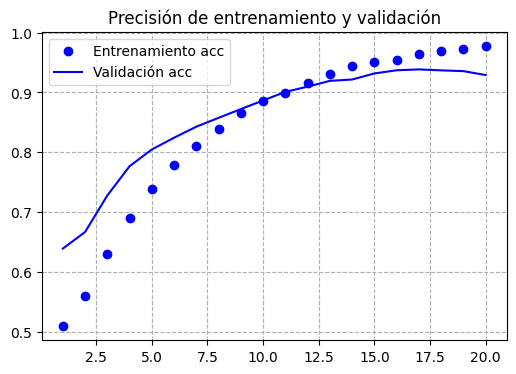

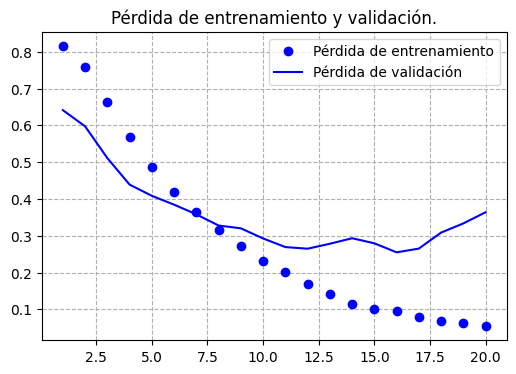

In [ ]:
plot_compare(history)


El **primer gráfico** muestra la comparación de la precisión y la pérdida del modelo durante el entrenamiento y la validación a lo largo de 20 épocas. Se aprecian las métricas de rendimiento del modelo, lo que permite evaluar su efectividad.

- **Precisión de Entrenamiento y Validación**: En la parte superior del gráfico, se observa una curva que representa la precisión del modelo durante el entrenamiento  y la precisión de validación. La precisión de entrenamiento aumenta de manera constante, alcanzando casi el 100% hacia la última época, lo que indica que el modelo se está ajustando bien a los datos de entrenamiento. Sin embargo, la precisión de validación muestra un aumento más moderado, lo que puede sugerir que el modelo no se está ajustando demasiado a los datos de validación.
  
- **Pérdida de Entrenamiento y Validación**: En la parte inferior del gráfico se presenta la pérdida, que es inversamente proporcional a la precisión. A medida que la precisión del entrenamiento aumenta, la pérdida disminuye. La pérdida de validación también disminuye, pero a un ritmo más lento, lo que podría indicar que el modelo está comenzando a sobreajustarse a los datos de entrenamiento.



El **segundo gráfico** ilustra la pérdida de entrenamiento y validación del modelo a lo largo de 20 épocas, proporcionando información sobre cómo el modelo se ajusta a los datos y su capacidad para generalizar.

- **Pérdida de Entrenamiento y Validación**: En la parte superior, se presentan dos curvas: una que representa la pérdida durante el entrenamiento y otra que muestra la pérdida de validación. La pérdida de entrenamiento disminuye de manera constante, lo que indica que el modelo está mejorando su ajuste a los datos de entrenamiento. En contraste, la pérdida de validación también disminuye, pero con un comportamiento más variable, lo que sugiere que el modelo puede estar enfrentando dificultades para generalizar a los datos no vistos.

- **Tendencias Observadas**: A medida que avanzan las épocas, la pérdida de entrenamiento se estabiliza en valores bajos, mientras que la pérdida de validación presenta picos y caídas, lo que puede ser un indicativo de que el modelo está empezando a sobreajustarse a los datos de entrenamiento.

# **Aumento de datos**

In [ ]:
# Implementamos el  aumento de datos para mejorar la capacidad de generalización de nuestro modelo.

Teniendo en cuenta lo señalado en la parte anterior se ha decidido realizan un aumento en los datos, esto nos va ayudar a mejorar el rendimiento y la capacidad de generalización del modelo ya que se esta ingresando una gran variedad een los datos que le serviran al modelo durante su entrenamiento. Asimismo, esto es muy importante ya que nos va  a permitir evitar un sobreajuste ya que se incremento los datos con la finalidad de que el modelo no memorize los detalles específicos de cada imagen y es mejor que aprenda características generalizables.


Teniendo en cuenta lo señalado en la anterior parte, se ha decidido realizar un aumento en los datos ya que mejora significativamente el rendimiento y la capacidad de generalización del modelo. Cuando nosotros introducimos una amplia variedad de transformaciones a las imágenes de entrenamiento, como rotaciones, desplazamientos y giros, se enriquece el conjunto de datos con ejemplos diversificados. Esto permite al modelo entrenarse en un espectro más amplio de posibles escenarios, mejorando así su capacidad para generalizar a nuevos datos no vistos durante el entrenamiento.

Además, la aumentación de datos es fundamental en la prevención del sobreajuste. El sobreajuste ocurre cuando en nuestro modelo aprende en exceso los detalles y patrones específicos de los datos de entrenamiento, perdiendo su efectividad para predecir correctamente con datos nuevos. Al aumentar el conjunto de datos con versiones modificadas de las imágenes originales, se evita que el modelo memorice detalles específicos, promoviendo en cambio el aprendizaje de características más generales y robustas. De esta manera, el modelo no solo se vuelve más eficiente, sino que también es capaz de identificar patrones relevantes en situaciones variadas, mejorando su aplicabilidad en entornos del mundo real.

Al nosotros contar con una aumentación de datos no solo incrementa la cantidad de datos disponibles para el entrenamiento, sino que también mejora la calidad del aprendizaje, proporcionando un conjunto de datos más representativo y diverso. Esto contribuye a desarrollar modelos más precisos y adaptables, capaces de realizar predicciones más confiables y precisas.



In [ ]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',input_shape=(256, 256, 3)))
model_1.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_1.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_1.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_1.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_1.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_1.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(512, activation='relu', name='dense_1'))
model_1.add(Dense(256, activation='relu', name='dense_2'))
model_1.add(Dense(1, activation='sigmoid', name='output'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
entrenamiento_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

prueba_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
        '/content/entrenamiento',
        target_size=tamanio_imagen,
        batch_size=batch_size,
        class_mode='binary')

validacion_generador = prueba_datagen.flow_from_directory(
        '/content/validacion',
        target_size=tamanio_imagen,
        batch_size=batch_size,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_1 = model_1.fit(entrenamiento_generador,
                        steps_per_epoch=12,
                        epochs=60,
                        validation_data=validacion_generador,
                        verbose=1)

Found 336 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 546ms/step - accuracy: 0.5209 - loss: 0.8075 - val_accuracy: 0.5278 - val_loss: 0.6875
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.5934 - loss: 0.6734 - val_accuracy: 0.7917 - val_loss: 0.6131
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.8254 - loss: 0.5936 - val_accuracy: 0.8333 - val_loss: 0.3265
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8951 - loss: 0.2755 - val_accuracy: 0.8472 - val_loss: 0.2811
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.9107 - loss: 0.2404 - val_accuracy: 0.9167 - val_loss: 0.1878
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9088 - loss: 0.2223 - val_accuracy: 0.9306 - val_loss: 0.1732
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.9200 - loss: 0.1678 - val_accuracy: 0.8194 - val_loss: 0.5307
Epoch 8/60
12/12 ━━━━━

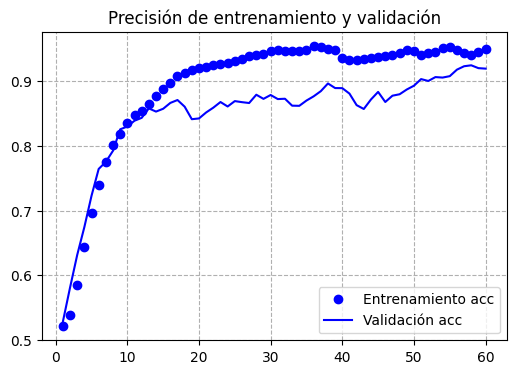

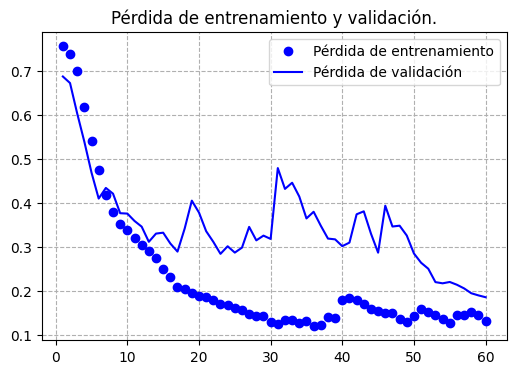

In [ ]:
plot_compare(history_1)

## Analicemos al primer gráfico

- **Gráfico de Precisión**: El gráfico muestra la precisión del modelo en el conjunto de entrenamiento y validación a lo largo de las épocas. La precisión de entrenamiento alcanza un valor cercano al 95%, lo que indica un buen ajuste del modelo a los datos de entrenamiento. Sin embargo, la precisión de validación se sitúa en aproximadamente el 93%, lo que sugiere que el modelo tiene un rendimiento ligeramente inferior en datos no vistos.

- **Gráfico de Pérdida**: La pérdida de entrenamiento es baja, lo que es positivo, pero es importante observar que la pérdida de validación nos indica que debe ser monitoreada para evitar el sobreajuste.


## Analicemos al segundo gráfico


- **Gráfico de Pérdida**: El gráfico ilustra la pérdida tanto en el conjunto de entrenamiento como en el de validación. Se observa que la pérdida de entrenamiento disminuye rápidamente al inicio del proceso, lo que indica que el modelo está aprendiendo de manera efectiva. La pérdida de validación también disminuye, aunque de manera más lenta, lo que sugiere que el modelo tiene un buen desempeño en datos no vistos.
- **Comparación de Pérdidas**: La pérdida de entrenamiento es consistentemente más baja que la pérdida de validación, lo que puede ser un indicativo de que el modelo se está ajustando bien a los datos de entrenamiento.


In [ ]:
model.save('modelo.h5')
save_history(history_1, 'history.bin')

# **Probando nuestro modelo**

Después de haber tomado todas las consideraciones necesarias para evaluar nuestro modelo, el siguiente paso es probarlo con nuevas imágenes. En este caso, nuestro objetivo es predecir si una imagen contiene un zorro o una cebra. Para realizar estas predicciones, primero debemos asegurarnos de que las imágenes estén almacenadas en un lugar accesible, como Google Drive, desde donde se puedan cargar y procesar fácilmente.

Una vez que las imágenes han sido cargadas, se procede a normalizarlas para garantizar que sus valores estén en un rango consistente. Luego, se expande la imagen a una dimensión adicional para que el modelo la interprete como un lote de una sola imagen. Esta preparación es crucial para que el modelo pueda hacer predicciones precisas basadas en lo aprendido durante el entrenamiento.

Finalmente, el modelo analiza el contenido de la imagen y, basándose en la probabilidad calculada, determina el resultado. Si la probabilidad es menor a 0.5, el modelo predice que la imagen es de una cebra; de lo contrario, predice que es un zorro. Esta metodología permite que el modelo aplique de manera efectiva lo aprendido durante el entrenamiento para clasificar nuevas imágenes con precisión.

In [ ]:
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargamos el modelo desde el archivo .h5
modelo_final= keras.models.load_model('/content/drive/MyDrive/modelo.h5')

In [ ]:
def predecir_imagen(imagen_ruta, model):

    # Cargar la imagen y cambiar el tamaño a 256x256
    img = image.load_img(imagen_ruta, target_size=(256, 256))
    img_array = image.img_to_array(img)

    # Normalizar la imagen (si fue necesario durante el entrenamiento)
    img_array = img_array / 255.0

    # Expandir las dimensiones para que sea un lote de una imagen
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer la predicción usando el modelo cargado
    prediccion = model.predict(img_array, verbose=0)

    if prediccion[0][0] < 0.5:
      return 'una cebra'
    else:
      return 'un zorro'

## **PRUEBA**

Para finalizar se carga las imagenes y nos brinda como resultado si la imagen es una cebra o si la imagen es un zorro y de esa manera se verifica si la predicción se esta realizando correctamnete.

In [ ]:
# Predicción de imágenes de cebras que nuestro modelo nunca vió

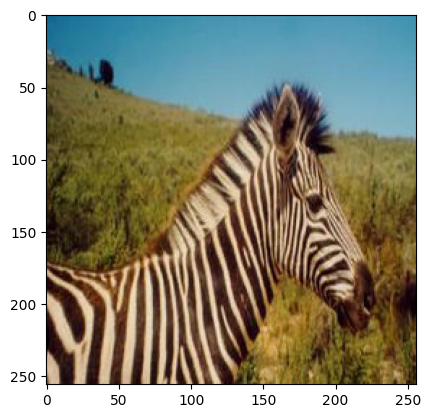

In [ ]:
imagen_ruta_cebra_1 = '/content/dataset/horse2zebra/testB/n02391049_10160.jpg'
img_cebra1 = image.load_img(imagen_ruta_cebra_1, target_size=(256, 256))
plt.imshow(img_cebra1)

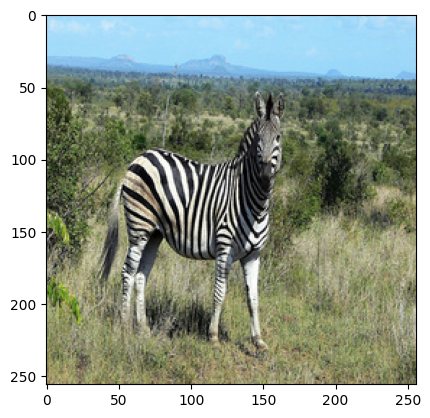

In [ ]:
imagen_ruta_cebra_2 = '/content/dataset/horse2zebra/testB/n02391049_1950.jpg'
img_cebra2 = image.load_img(imagen_ruta_cebra_2, target_size=(256, 256))
plt.imshow(img_cebra2)

In [ ]:
resultado1 = predecir_imagen(imagen_ruta_cebra_1, modelo_final)
print(f"Predicción: El animal de la imagen es {resultado1}.")

Predicción: El animal de la imagen es una cebra.


In [ ]:
resultado2 = predecir_imagen(imagen_ruta_cebra_2, modelo_final)
print(f"Predicción: El animal de la imagen es {resultado2}.")

Predicción: El animal de la imagen es una cebra.


In [ ]:
# Predicción de imágenes de zorros que nuestro modelo nunca vió

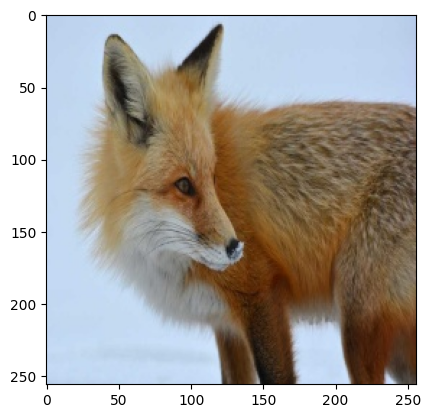

In [ ]:
imagen_ruta_zorro_1 = '/content/dataset/images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/7MXW71IBKICK.jpg'
img_zorro1 = image.load_img(imagen_ruta_zorro_1, target_size=(256, 256))
plt.imshow(img_zorro1)

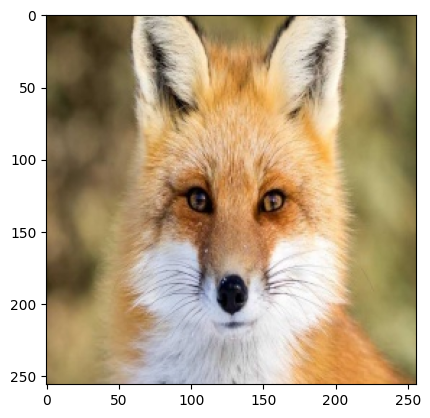

In [ ]:
imagen_ruta_zorro_2 = '/content/dataset/images.cv_8rk8h3aklzqjr2tcx76b7/data/test/animal fox/GYXLTD0UP3GB.jpg'
img_zorro2 = image.load_img(imagen_ruta_zorro_2, target_size=(256, 256))
plt.imshow(img_zorro2)

In [ ]:
resultado3 = predecir_imagen(imagen_ruta_zorro_1, modelo_final)
print(f"Predicción: El animal de la imagen es {resultado3}.")

Predicción: El animal de la imagen es un zorro.


In [ ]:
resultado4 = predecir_imagen(imagen_ruta_zorro_1, modelo_final)
print(f"Predicción: El animal de la imagen es {resultado4}.")

Predicción: El animal de la imagen es un zorro.


### REFERENCIAS:

[1] P. R. de los Santos, "Datos de entrenamiento vs datos de test," Telefónica Tech, Jan. 24, 2022. [Online]. Available: https://telefonicatech.com/blog/datos-entrenamiento-vs-datos-de-test. [Accessed: Aug. 30, 2024].

[2] I. Goodfellow, Y. Bengio, and A. Courville, Deep Learning. Cambridge, MA: MIT Press, 2016. [Online]. Available: https://www.deeplearningbook.org/. [Accessed: Aug. 30, 2024].

[3] N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting," Journal of Machine Learning Research, vol. 15, no. 1, pp. 1929-1958, 2014. [Online]. Available: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf. [Accessed: Aug. 30, 2024].

[4] C. M. Bishop, Pattern Recognition and Machine Learning. New York: Springer, 2006. [Online]. Available: https://www.springer.com/gp/book/9780387310732. [Accessed: Aug. 30, 2024].


[5] T. Hastie, R. Tibshirani, and J. Friedman, The Elements of Statistical Learning: Data Mining, Inference, and Prediction. New York: Springer, 2009. [En línea]. Disponible: https://link.springer.com/book/10.1007/978-0-387-84858-7 [Accedido: 30-ago-2024].

[6] P. Hegemony, "494 Fox labeled image dataset," Kaggle, 2021. [En línea]. Disponible: https://www.kaggle.com/datasets/peacehegemony/494-fox-labeled-image-dataset. [Accedido: 30-ago-2024].

[7] A. Dertat, "Applied Deep Learning - Part 4: Convolutional Neural Networks," Towards Data Science, Nov. 8, 2017. [En línea]. Disponible: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks. [Accedido: 30-ago-2024].
